# A Text Mining Approach to Analyze The Cyber Security Related Articles

## PART-3: Text Mining

__Feature Engineering with NLP techniques__


__Importing of Required Libraries__

In [33]:
import nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from autocorrect import Speller
import pickle
import re


import spacy
import en_core_web_sm
from spacy import displacy

import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

__Loading Data__

As mentioned Part-2 that pandas parquet options doesn't support timedelta type. So we need to use __fastparquet__ option, to keep the timedelta type format.

In [2]:
df_sum=pd.read_parquet('df_sum_parquet.gzip',engine='fastparquet')
df_investigator_cyber=pd.read_parquet('df_investigator_cyber_parque.gzip',engine='fastparquet')
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


### A-) Word Frequency

__Replacing Of Contraction Words__

In [3]:
#Replace contraction words to alternative forms before tokenization
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":" "}

df_sum['Abstract']=df_sum['Abstract'].replace(replacement_patterns, regex=True)
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


__Merge All Values in Abstract Columns to A Single String__

In [4]:
abstract_list=df_sum['Abstract'].tolist()
abstract_sum=' '.join(abstract_list)
print('Total character number of all Abstract columns is: {}'.format(len(abstract_sum)))

Total character number of all Abstract columns is: 13654766


__Tokenization and LowerCase__

In [5]:
#word tokenization
wrd_list = nltk.word_tokenize(abstract_sum)

#lowercase
wrd_list=[w.lower() for w in wrd_list]
print('Total lowercase words: {}'.format(len(wrd_list)))

Total lowercase words: 2136906


__Remove Numbers__

In [6]:
#remove numbers
wrd_list_alpha=[w for w in wrd_list if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(len(wrd_list_alpha)))

Total words consist of only alphabets: 1857334


__Remove Written Form of Numbers__

In [7]:
#Create numbers in written form for ignoring
num_written= {1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', \
             6: 'six', 7: 'seven', 8: 'eight', 9: 'nine', 10: 'ten', \
            11: 'eleven', 12: 'twelve', 13: 'thirteen', 14: 'fourteen', \
            15: 'fifteen', 16: 'sixteen', 17: 'seventeen', 18: 'eighteen', \
            19: 'nineteen', 20: 'twenty', 30: 'thirty', 40: 'forty', \
            50: 'fifty', 60: 'sixty', 70: 'seventy', 80: 'eighty', \
            90: 'ninety', 0: 'zero'}

num_list=list(np.arange(0,100))

num2words_list=[]

def num2words(n):
    try:
        return num_written[n]
    except:
        try:
            return num2words(n-n%10) + num2words(n%10)
        except:
            return 'None'

        
for num in num_list:
    num2words_list.append(num2words(num))
    
wrd_list_rm_written_form = [w for w in wrd_list_alpha if w not in num2words_list]
print('Total words consist of only alphabets: {}'.format(len(wrd_list_rm_written_form)))

Total words consist of only alphabets: 1852061


__Remove Stopwords__

In [8]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via'])

wrd_list_rm_stopwords = [w for w in wrd_list_rm_written_form if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(len(wrd_list_rm_stopwords)))

Total words after removing stopwords: 1132777


__Remove 1-Length Words__

In [9]:
#remove 1-len words
wrd_list_one_len = [w for w in wrd_list_rm_stopwords if len(w)>=2]

print('Total words after removing 1-len words: {}'.format(len(wrd_list_one_len)))

Total words after removing 1-len words: 1131875


__Counting The Words Frequency__

In [10]:
freq_dict_before=nltk.FreqDist(wrd_list_one_len)
print('Total unique words before lemmatization: {}'.format(len(freq_dict_before)))

Total unique words before lemmatization: 29726


In [11]:
print('First 50 frequency words:\n{}'.format(freq_dict_before.most_common(50)))

First 50 frequency words:
[('research', 15756), ('project', 13500), ('data', 10357), ('students', 7460), ('systems', 6963), ('new', 6831), ('science', 6174), ('security', 4625), ('development', 4236), ('system', 4159), ('information', 4023), ('support', 3925), ('program', 3870), ('community', 3680), ('education', 3633), ('university', 3622), ('engineering', 3607), ('design', 3590), ('learning', 3518), ('using', 3496), ('network', 3481), ('use', 3479), ('develop', 3395), ('software', 3328), ('provide', 3229), ('tools', 3060), ('cyberinfrastructure', 2987), ('materials', 2930), ('technology', 2855), ('computing', 2791), ('cybersecurity', 2770), ('researchers', 2751), ('scientific', 2646), ('nsf', 2603), ('applications', 2585), ('broader', 2566), ('computer', 2550), ('work', 2543), ('computational', 2532), ('infrastructure', 2492), ('award', 2387), ('analysis', 2384), ('including', 2382), ('control', 2356), ('national', 2351), ('methods', 2351), ('high', 2320), ('used', 2308), ('activitie

__Lemmatization__

In [12]:
#Lemmatization
lemmatizer = WordNetLemmatizer()

wrd_list_lemmas = [lemmatizer.lemmatize(w) for w in wrd_list_one_len]

#Recounting the Words Frequency
freq_dict=nltk.FreqDist(wrd_list_lemmas)

print('Total unique words after lemmatization: {}'.format(len(freq_dict)))


Total unique words after lemmatization: 26361


In [13]:
print('First 50 frequency words:\n{}'.format(freq_dict.most_common(50)))

First 50 frequency words:
[('research', 15763), ('project', 14922), ('system', 11122), ('data', 10357), ('student', 8732), ('science', 7201), ('new', 6831), ('network', 5412), ('program', 5309), ('community', 4828), ('technology', 4686), ('support', 4682), ('security', 4625), ('development', 4450), ('impact', 4424), ('university', 4209), ('information', 4023), ('model', 4019), ('design', 3901), ('application', 3695), ('tool', 3678), ('education', 3636), ('engineering', 3607), ('learning', 3518), ('using', 3496), ('material', 3493), ('use', 3479), ('develop', 3395), ('software', 3330), ('provide', 3229), ('cyberinfrastructure', 2987), ('researcher', 2878), ('computer', 2852), ('resource', 2843), ('infrastructure', 2829), ('process', 2814), ('activity', 2803), ('approach', 2799), ('computing', 2791), ('cybersecurity', 2770), ('study', 2766), ('method', 2750), ('analysis', 2665), ('scientific', 2646), ('work', 2639), ('nsf', 2605), ('broader', 2566), ('computational', 2532), ('workshop', 

__Saving The Result__

In [14]:
df_FreqDist=pd.DataFrame({'Words':list(freq_dict.keys()),'Count':list(freq_dict.values())})
df_FreqDist.sort_values(by=['Count'],ascending=False,inplace=True)
df_FreqDist=df_FreqDist.reset_index(drop=True)
df_FreqDist.to_csv('FreqDist.csv')
df_FreqDist.head(3)

,Words,Count
0,research,15763
1,project,14922
2,system,11122


## B-) Clustering and Topic Modeling

In [98]:
#Create a new DataFrame
df_sum2=df_sum[['AwardID','Abstract']]
df_sum2.head(2)

,AwardID,Abstract
0,0110599,The investigators will conduct a series of exp...
1,0112426,This program produces a cadre of computer scie...


__Replacing Of Contraction Words__

In [100]:
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":" "}

df_sum2['Abstract'].replace(replacement_patterns, regex=True, inplace=True)
df_sum2.head(2)

,index,AwardID,Abstract
0,430,0646965,"This proposal, planning a workshop to examine ..."


__Removing Unneccesery Words__

We use __NER__ (Named Entity Recognition) function of __spacy__ library to detect named entities (people, places, organizations, dates, times etc.) from the text. After analyzing this words, we understood that they are unnecessary for clustering.

An example of visualization of NER:

In [17]:
#define the nlp object
nlp = en_core_web_sm.load()

doc=nlp(str(df_sum2['Abstract'][1]))

displacy.render(doc, style="ent",jupyter=True)

In [103]:
#create a list for NER
NER_list=[]

#Find
for n in range(df_sum2.shape[0]):
    doc=nlp(str(df_sum2['Abstract'][n]))

    for ent in doc.ents:
        NER_list.append(ent.text)
        
NER_list = [' {0} '.format(elem) for elem in NER_list] #Add space to begins and ends of all NERs

print('Total NER words: {}'.format(len(NER_list)))
NER_list=list(set(NER_list)) #for unique elements in list
print('Total unique NER words: {}'.format(len(NER_list)))

print('Total words before removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

for NER in NER_list:
    df_sum2['Abstract']=df_sum2['Abstract'].str.replace(NER,' ',regex=False) #Because,some NERs have punctuation
print('Total words after removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

0
Total NER words: 6
Total unique NER words: 6
Total words before removing NER: 2448
Total words after removing NER: 2419


In [105]:
df_sum2["Abstract"][0]

'This proposal, planning a workshop to examine questions regarding the security of the cyber infrastructure, aims at gathering the main infrastructure security stakeholders with interdisciplinary expertise on data access, information security, computer network security, data and database security, privacy, and data confidentiality to provide insights and directions toward future strategies for protecting the infrastructure. With the goal of strengthening the security of the infrastructure at all levels, the workshop seeks to determine what questions have to be answered for short and long-term strategies to be successful. Looking at both technical and policy issues and the interaction between the two, the work addresses fundamental questions of infrastructure protection.   Computer security has main thrusts: Confidentiality, Integrity, and (CIA). Security of Infrastructure involves the dynamic interaction of many components and at different levels: Authentication, Authorization, Access 

__Tokenization and LowerCase__

In [64]:
#word tokenization and lowercase
df_sum2['Abstract_Tokens'] = df_sum2['Abstract'].str.lower().apply(nltk.word_tokenize)
print('Total words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words: 375


,index,AwardID,Abstract,Abstract_Tokens
0,430,0646965,"This proposal, planning a workshop to examine ...","[this, proposal, ,, planning, a, workshop, to,..."


__Remove Numbers__

In [65]:
#remove numbers
for n in range(df_sum2.shape[0]):
    print(n)
    df_sum2['Abstract_Tokens'][n]=[w for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n]) if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

0
Total words consist of only alphabets: 322


,index,AwardID,Abstract,Abstract_Tokens
0,430,0646965,"This proposal, planning a workshop to examine ...","[this, proposal, planning, a, workshop, to, ex..."


__Remove Stopwords__

In [66]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via'])

#extend the stopwords list with unneccessary words
stopwords_list.extend(['abstract','program'])


for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n]) if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing stopwords: 185


,index,AwardID,Abstract,Abstract_Tokens
0,430,0646965,"This proposal, planning a workshop to examine ...","[proposal, planning, workshop, examine, questi..."


In [68]:
df_sum2["Abstract_Tokens"][0]

['proposal',
 'planning',
 'workshop',
 'examine',
 'questions',
 'regarding',
 'security',
 'cyber',
 'infrastructure',
 'aims',
 'gathering',
 'main',
 'infrastructure',
 'security',
 'stakeholders',
 'interdisciplinary',
 'expertise',
 'data',
 'access',
 'information',
 'security',
 'computer',
 'nerk',
 'security',
 'data',
 'database',
 'security',
 'privacy',
 'data',
 'confidentiality',
 'provide',
 'insights',
 'directions',
 'toward',
 'future',
 'strategies',
 'protecting',
 'infrastructure',
 'goal',
 'strengthening',
 'security',
 'infrastructure',
 'levels',
 'workshop',
 'seeks',
 'determine',
 'questions',
 'answered',
 'short',
 'strategies',
 'successful',
 'looking',
 'technical',
 'policy',
 'issues',
 'interaction',
 'work',
 'addresses',
 'fundamental',
 'questions',
 'infrastructure',
 'protection',
 'computer',
 'security',
 'main',
 'thrusts',
 'confidentiality',
 'integrity',
 'security',
 'infrastructure',
 'involves',
 'dynamic',
 'interaction',
 'components

__Lemmatization__

In [69]:
#Lemmatization
lemmatizer = WordNetLemmatizer()

for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[lemmatizer.lemmatize(w) for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n])]

print('Total words after lemmatization: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after lemmatization: 185


,index,AwardID,Abstract,Abstract_Tokens
0,430,0646965,"This proposal, planning a workshop to examine ...","[proposal, planning, workshop, examine, questi..."


In [70]:
df_sum2["Abstract_Tokens"][0]

['proposal',
 'planning',
 'workshop',
 'examine',
 'question',
 'regarding',
 'security',
 'cyber',
 'infrastructure',
 'aim',
 'gathering',
 'main',
 'infrastructure',
 'security',
 'stakeholder',
 'interdisciplinary',
 'expertise',
 'data',
 'access',
 'information',
 'security',
 'computer',
 'nerk',
 'security',
 'data',
 'database',
 'security',
 'privacy',
 'data',
 'confidentiality',
 'provide',
 'insight',
 'direction',
 'toward',
 'future',
 'strategy',
 'protecting',
 'infrastructure',
 'goal',
 'strengthening',
 'security',
 'infrastructure',
 'level',
 'workshop',
 'seek',
 'determine',
 'question',
 'answered',
 'short',
 'strategy',
 'successful',
 'looking',
 'technical',
 'policy',
 'issue',
 'interaction',
 'work',
 'address',
 'fundamental',
 'question',
 'infrastructure',
 'protection',
 'computer',
 'security',
 'main',
 'thrust',
 'confidentiality',
 'integrity',
 'security',
 'infrastructure',
 'involves',
 'dynamic',
 'interaction',
 'component',
 'different',
 

__Remove 1-Length Words__

Punctuation
Punctuation are the unnecessary symbols that are in our corpus documents,

In [25]:
#remove 1-len words
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n]) if len(w)>=2]
print('Total words after removing 1-len words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing 1-len words: 1030639


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a of experimen...,"[investigator, conduct, experiment, foc, cruci..."
1,0112426,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


In [ ]:
'''
tokens_str=df_sum['Abstract_Tokens'].tolist()
all_tokens_str=' '.join(tokens_str)
print()
'''

Abstract2 uniqi!!!
#Recounting the Words Frequency
freq_dict=nltk.FreqDist(wrd_list_lemmas)

print('Total unique words after lemmatization: {}'.format(len(freq_dict)))


__Convert Tokens To String Again__

In [27]:
df_sum2['Abstract2']=df_sum2['Abstract']
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract2'][n]=' '.join([str(item) for item in df_sum2['Abstract_Tokens'][n]])
df_sum2.head(2)

,AwardID,Abstract,Abstract_Tokens,Abstract2
0,0110599,The investigators will conduct a of experimen...,"[investigator, conduct, experiment, foc, cruci...",investigator conduct experiment foc crucial su...
1,0112426,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong spiali...


__TfidfVectorizer__

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X = v.fit_transform(df_sum2['Abstract2'])
X.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
v.get_feature_names()[:10]

['aa',
 'aaaaa',
 'aan',
 'aand',
 'aandm',
 'aandp',
 'aandt',
 'aaron',
 'aation',
 'aator']

In [30]:
len(v.vocabulary_)

22470

__Create New DataFrame__

In [31]:
df = pd.DataFrame(data=X.toarray(), columns=v.get_feature_names())
df.head(2)

,aa,aaaaa,aan,aand,aandm,aandp,aandt,aaron,aation,aator,...,zps,zr,zte,ztipanots,zurich,zwitterionic,µm,étale,ís,ückel
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__KMeans Clustering__

2 finish...
3 finish...
4 finish...
5 finish...


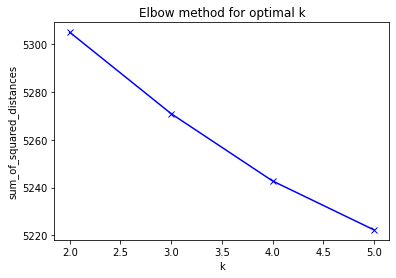

In [40]:

#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
sum_of_squared_distances = []
K = range(2,6)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(df)
    sum_of_squared_distances.append(k_means.inertia_)
    print(k, 'finish...')
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.show()

In [35]:

k_means = KMeans(n_clusters=3)
#Run the clustering algorithm
model = k_means.fit(df)
model
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)
y_hat

array([1, 0, 0, ..., 1, 1, 1])

In [39]:
labels=list(y_hat)
df_sum2['Label']=labels
df_sum2.to_csv('df_sum_clustering.csv',sep=';')
df_sum2.head(2)

,AwardID,Abstract,Abstract_Tokens,Abstract2,Label
0,0110599,The investigators will conduct a of experimen...,"[investigator, conduct, experiment, foc, cruci...",investigator conduct experiment foc crucial su...,1
1,0112426,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong spiali...,0


In [37]:
df_sum2[df_sum2['Label']==0]

,AwardID,Abstract,Abstract_Tokens,Abstract2,Label
1,0112426,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong spiali...,0
2,0114016,This projt relieves the shortage of qualified ...,"[projt, relief, shortage, qualified, informati...",projt relief shortage qualified information as...,0
6,0201873,In response to the national need for informati...,"[response, national, need, information, thnolo...",response national need information thnology wo...,0
15,0210334,"Utica ollege (U), yrace (U), and the tate of...","[utica, ollege, yrace, tate, ew, thnology, erk...",utica ollege yrace tate ew thnology erkimer ot...,0
18,0221722,This projt will ex the framework for supportin...,"[projt, ex, framework, supporting, surity, res...",projt ex framework supporting surity reseh con...,0
...,...,...,...,...,...
5181,1441724,Operating systems (O) form the core of the trt...,"[operating, system, form, core, trted, computi...",operating system form core trted computing bas...,0
5235,1534602,The broader impact/commercial potial of this m...,"[broader, potial, mall, bine, eseh, projt, dra...",broader potial mall bine eseh projt dramatic i...,0
5274,1642134,erk infrastructure at campes is complex and s...,"[erk, infrastructure, campes, complex, sophist...",erk infrastructure campes complex sophisticate...,0
5275,1642158,erk infrastructure at campes is complex and s...,"[erk, infrastructure, campes, complex, sophist...",erk infrastructure campes complex sophisticate...,0


In [ ]:
df_sum2.head(30)